<a href="https://colab.research.google.com/github/LorenzoBioinfo/DrugDiscoveryML/blob/Dev/VirtualScreening_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Virtual Screening Pipeline — BACE1 Inhibitor Discovery

## Project Overview

This notebook implements a **ligand-based virtual screening pipeline** applied to the discovery
of potential inhibitors of **BACE1 (Beta-Secretase 1)**, a key therapeutic target in
**Alzheimer's Disease**.

BACE1 is a transmembrane aspartyl protease responsible for the cleavage of the amyloid
precursor protein (APP), leading to the production of amyloid-β peptides — the main
component of amyloid plaques found in Alzheimer's patients. Inhibiting BACE1 is therefore
one of the most studied strategies to slow or prevent neurodegeneration.

## Workflow

Starting from a large library of natural compounds (COCONUT) , we apply a sequential
filtering and ranking pipeline:

1. **Library Loading** — import raw compound library in SDF format
2. **Physicochemical Filtering** — Lipinski's Rule of Five to ensure drug-likeness
3. **Structural Alerts Filtering** — PAINS and BRENK filters to remove reactive,
   toxic or otherwise undesirable compounds
4. **Fingerprint Generation** — ECFP6 molecular fingerprints
5. **Similarity Search** — Tanimoto similarity against known BACE1 inhibitors (ChEMBL)
6. **Ranking & Analysis** — ranked list of candidate molecules for further investigation

## Data Sources

- **Screening Library**: COCONUT
- **Reference Actives**: BACE1 inhibitors from ChEMBL (IC50 < 1000 nM, target ID: CHEMBL4822)

In [1]:
!pip install numpy>=1.26.4,<2.0.0 scipy>=1.15.0 pandas>=2.2.3 matplotlib>=3.10.0 seaborn>=0.13.2  scikit-learn>=1.6.0 tqdm>=4.67.1 joblib>=1.4.0 jupyterlab>=4.3.0
!pip install chembl_webresource_client

/bin/bash: line 1: 2.0.0: No such file or directory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 3.7 MB/s eta 0:00:00


In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 24.4 MB/s eta 0:00:00


## Utils functions



In [3]:
# Core data science packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Chemical informatics packages
from rdkit import Chem
from rdkit.Chem import (
    AllChem,
    Draw,
    PandasTools,
    FilterCatalog,
    Descriptors,
    MolFromSmiles,
    MolFromSmarts,
)
from rdkit import DataStructs
from rdkit.Chem.rdFingerprintGenerator import AdditionalOutput, GetMorganGenerator


# Set random seed for reproducibility
np.random.seed(42)
def save_molecular_dataframe(df, filename, chapter="ch01", compress=True):
    """
    Save a pandas DataFrame containing molecular data to a pickle file.

    This function handles dataframes that contain mixed data types including
    RDKit Mol objects, which cannot be saved with standard methods like
    df.to_csv() or df.to_parquet().

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to save, which may contain RDKit Mol objects
    filename : str
        Name of the file (without path)
    chapter : str
        Chapter identifier for directory organization
    compress : bool
        Whether to use compression (recommended for large dataframes)

    Returns:
    --------
    str
        Path to the saved file
    """
    # Create the artifacts directory if it doesn't exist
    save_dir = Path(f"artifacts/{chapter}/")
    save_dir.mkdir(parents=True, exist_ok=True)

    # Add .pkl or .pkl.gz extension if not present
    if not filename.endswith('.pkl') and not filename.endswith('.pkl.gz'):
        filename = f"{filename}.pkl"

    # Add compression extension if requested
    if compress and not filename.endswith('.gz'):
        filename = f"{filename}.gz"

    # Full path for saving
    save_path = save_dir / filename

    # Save the dataframe using pickle with optional compression
    protocol = pickle.HIGHEST_PROTOCOL  # Use the most efficient protocol

    print(f"Saving dataframe with {len(df)} rows to {save_path}...")
    with open(save_path, 'wb') as f:
        pickle.dump(df, f, protocol=protocol)

    file_size_mb = os.path.getsize(save_path) / (1024 * 1024)
    print(f"Successfully saved dataframe ({file_size_mb:.1f} MB)")

    return str(save_path)

def load_molecular_dataframe(filename, chapter="ch01"):
    """
    Load a pandas DataFrame containing molecular data from a pickle file.

    Parameters:
    -----------
    filename : str
        Name of the file to load (without path)
    chapter : str
        Chapter identifier for directory organization

    Returns:
    --------
    pandas.DataFrame
        The loaded DataFrame
    """
    # Create the full file path
    file_dir = Path(f"artifacts/{chapter}/")

    # Handle different possible file extensions
    if not (filename.endswith('.pkl') or filename.endswith('.pkl.gz')):
        # Try both compressed and uncompressed versions
        if (file_dir / f"{filename}.pkl.gz").exists():
            filename = f"{filename}.pkl.gz"
        else:
            filename = f"{filename}.pkl"

    file_path = file_dir / filename

    # Check if file exists
    if not file_path.exists():
        raise FileNotFoundError(f"File not found: {file_path}")

    print(f"Loading molecular dataframe from {file_path}...")
    start_time = pd.Timestamp.now()

    # Load the dataframe
    with open(file_path, 'rb') as f:
        df = pickle.load(f)

    # Calculate loading time
    load_time = (pd.Timestamp.now() - start_time).total_seconds()

    print(f"Successfully loaded dataframe with {len(df)} rows and {len(df.columns)} columns")
    print(f"Loading time: {load_time:.2f} seconds")

    return df

def list_saved_dataframes(chapter="ch01"):
    """
    List all saved dataframes in the artifacts directory.

    Parameters:
    -----------
    chapter : str
        Chapter identifier for directory organization

    Returns:
    --------
    list
        List of available dataframe filenames
    """
    save_dir = Path(f"artifacts/{chapter}/")

    if not save_dir.exists():
        print(f"No artifacts directory found for chapter {chapter}")
        return []

    # Get all pickle files
    saved_files = list(save_dir.glob("*.pkl*"))

    if not saved_files:
        print(f"No saved dataframes found in {save_dir}")
        return []

    # Print information about available files
    print(f"Available saved dataframes in {save_dir}:")
    file_info = []

    for file_path in saved_files:
        file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
        modified_time = pd.Timestamp.fromtimestamp(os.path.getmtime(file_path))

        file_info.append({
            'filename': file_path.name,
            'size_mb': file_size_mb,
            'modified': modified_time
        })

    # Sort by modification time (newest first)
    file_info.sort(key=lambda x: x['modified'], reverse=True)

    # Display the information
    for info in file_info:
        print(f"  {info['filename']} ({info['size_mb']:.1f} MB, modified: {info['modified']})")

    return [info['filename'] for info in file_info]



# Matplotlib and Seaborn setup for consistent visualizations
def setup_visualization_style():
    """Configure consistent visualization style for the notebook"""
    colors = ["#A20025", "#6C8EBF"]  # Define a color palette
    sns.set_palette(sns.color_palette(colors))
    plt.rcParams['axes.titlesize'] = 18
    plt.rcParams['axes.labelsize'] = 16

setup_visualization_style()
%matplotlib inline


def setup_rdkit_drawing():
    """Configure RDKit drawing settings for consistent molecular visualizations"""
    d2d = Draw.MolDraw2DSVG(-1, -1)
    dopts = d2d.drawOptions()
    dopts.useBWAtomPalette()
    dopts.setHighlightColour((.635, .0, .145, .4))
    dopts.baseFontSize = 1.0
    dopts.additionalAtomLabelPadding = 0.15

    return dopts

rdkit_drawing_options = setup_rdkit_drawing()

### <b> <font color='#A20025'> Download and Prepare Data Files

In [4]:
from rdkit import RDLogger
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit import RDLogger
from rdkit import Chem
from tqdm import tqdm


In [8]:
from os.path import supports_unicode_filenames
import pandas as pd
import os
import zipfile
import io
import pandas as pd
from chembl_webresource_client.new_client import new_client
import requests
import pandas as pd
import zipfile
from rdkit import Chem, RDLogger
from tqdm import tqdm
import numpy as np

os.makedirs('data', exist_ok=True)
# ################## COCONUT DATASET
# # ============================================================
# # STEP 1 — Download CSV zip
# # ============================================================

url      = "https://coconut.s3.uni-jena.de/prod/downloads/2026-02/coconut_csv_lite-02-2026.zip"
out_path = "data/coconut_csv.zip"

print("Downloading COCONUT CSV...")
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))

with open(out_path, 'wb') as f, tqdm(
    total=total_size, unit='B', unit_scale=True,
    unit_divisor=1024, desc="COCONUT CSV"
) as bar:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)
        bar.update(len(chunk))

# # ============================================================
# # STEP 2 — Extract and load CSV
# # ============================================================
print("\nExtracting...")
with zipfile.ZipFile(out_path, 'r') as z:
    print(f"Files in zip: {z.namelist()}")
    z.extractall('data/coconut_csv/')

import glob
csv_file = glob.glob('data/coconut_csv/*.csv')[0]
print(f"Loading: {csv_file}")

 # First 150000
N = 150_000
df_raw = pd.read_csv(csv_file, nrows=N)
print(f"Columns available: {df_raw.columns.tolist()}")

# #
smiles_col = [c for c in df_raw.columns if 'smiles' in c.lower()][0]
id_col     = [c for c in df_raw.columns if 'id' in c.lower()][0]
df_raw = df_raw[[id_col, smiles_col]].rename(
    columns={smiles_col: 'SMILES', id_col: 'COCONUT_ID'}
).dropna(subset=['SMILES']).reset_index(drop=True)

print(f"Rows after dropna: {len(df_raw)}")

# # ============================================================
# # STEP 3 —Add mol from Smiles
# # ============================================================

def smiles_to_mol(df, smiles_col='SMILES', mol_col='mol'):
    """
    Crea colonna mol RDKit a partire da SMILES.
    Molto più leggero di caricare un SDF completo.
    """
    RDLogger.DisableLog('rdApp.*')

    mols      = []
    n_invalid = 0

    for smi in tqdm(df[smiles_col], desc="Building mol objects", unit="mol"):
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            n_invalid += 1
        mols.append(mol)

    df[mol_col] = mols

    RDLogger.EnableLog('rdApp.*')

    print(f"Valid molecules  : {df[mol_col].notnull().sum()}")
    print(f"Invalid molecules: {n_invalid}")

    return df[df[mol_col].notnull()].reset_index(drop=True)


df_library = smiles_to_mol(df_raw)
df_library.to_csv('data/coconut_library.csv', index=False)

print(f"\nFinal library size: {len(df_library)} molecules")
print(df_library.head(3))

# ============================================================
# REFERENCE SET — BACE1 da ChEMBL
# ============================================================

activity = new_client.activity
BACE1_ID = 'CHEMBL4822'

print(f"Downloading BACE1 activities from ChEMBL ({BACE1_ID})...")

acts = activity.filter(
    target_chembl_id=BACE1_ID,
    standard_type='IC50',
    assay_type='B'
).only([
    'molecule_chembl_id',
    'canonical_smiles',
    'standard_value',
    'standard_units',
    'standard_relation'
])

df_ref = pd.DataFrame(list(acts))
print(f"Raw records: {len(df_ref)}")

# ============================================================
# Cleaning
# ============================================================

# Remove molecules without SMILES o IC50
df_ref = df_ref.dropna(subset=['canonical_smiles', 'standard_value'])

# Convert to IC50
df_ref['standard_value'] = pd.to_numeric(df_ref['standard_value'], errors='coerce')

#
df_ref = df_ref[df_ref['standard_units'] == 'nM']

#
df_ref = df_ref[df_ref['standard_relation'] == '=']

# Remove duplicates
df_ref = (df_ref
    .groupby('canonical_smiles', as_index=False)
    .agg({'standard_value': 'mean', 'molecule_chembl_id': 'first'})
    .rename(columns={'canonical_smiles': 'SMILES', 'standard_value': 'IC50_nM'})
)

#
df_ref['pIC50'] = -df_ref['IC50_nM'].apply(lambda x: np.log10(x * 1e-9))
df_ref['active'] = (df_ref['IC50_nM'] < 1000).astype(int)

df_ref_actives = df_ref[df_ref['active'] == 1].copy()

#Save
df_ref.to_csv('data/bace1_full.csv', index=False)
df_ref_actives.to_csv('data/bace1_actives.csv', index=False)

# ============================================================
# Summary
# ============================================================
print("\n--- Summary ---")
print(f"Total unique compounds : {len(df_ref)}")
print(f"Active (IC50 < 1000 nM): {len(df_ref_actives)}")
print(f"Inactive               : {len(df_ref) - len(df_ref_actives)}")
print(f"\nIC50 range: {df_ref['IC50_nM'].min():.2f} - {df_ref['IC50_nM'].max():.2f} nM")
print(f"pIC50 range: {df_ref['pIC50'].min():.2f} - {df_ref['pIC50'].max():.2f}")
print(df_ref.head(3))


# ============================================================

print(f"Library          : {len(df_library)} natural products (COCONUT)")


Raw records: 13677

--- Summary ---
Total unique compounds : 8205
Active (IC50 < 1000 nM): 5605
Inactive               : 2600

IC50 range: 0.00 - 500000379.50 nM
pIC50 range: 0.30 - 12.00
                                              SMILES  IC50_nM  \
0  Br.CS(=O)(=O)N(c1cccc(C(=O)N[C@@H](Cc2ccccc2)[...   4570.0   
1           Brc1ccc(-c2nnc(N3CCN(c4ccccn4)CC3)o2)cc1    126.0   
2                Brc1ccc(/C=N\C2CCN(Cc3ccccc3)C2)cc1   1752.0   

  molecule_chembl_id     pIC50  active  
0      CHEMBL1788375  5.340084       0  
1      CHEMBL4779999  6.899629       1  
2      CHEMBL4794000  5.756466       0  
Library          : 149999 natural products (COCONUT)


## Lipinski filtering
Great! We have downloaded our library of natural compounds and our target library. We can now proceed by filtering the compound library according to Lipinski’s Rule of Five criteria."

Lipinski’s Rule of Five states that, in general, an orally active drug should have:

* No more than 5 hydrogen bond donors (HBD)

* No more than 10 hydrogen bond acceptors (HBA)

* A molecular weight ≤ 500 Da

* A logP ≤ 5

Compounds that violate more than one of these criteria are less likely to have good oral bioavailability.

We'll use molecular descriptors from RDKIT to filter compounds based on Lipinski's Rule of Five.

In [10]:
def list_available_descriptors(limit=10):
    """
    List available molecular descriptors in RDKit.

    Parameters:
    -----------
    limit : int
        Number of descriptors to show (0 for all)
    """
    descriptors = Descriptors._descList
    print(f"RDKit has {len(descriptors)} molecular descriptors available")

    if limit > 0:
        print(f"Showing first {min(limit, len(descriptors))} descriptors:")
        for name, func in descriptors[:limit]:
            print(f"- {name}")

    return {desc: func for desc, func in descriptors}

# List available descriptors
RDKIT_DESCRIPTORS = list_available_descriptors(limit=10)



def calculate_ro5_descriptors(df, mol_col='mol'):
    """
    Calculate Lipinski's Rule of Five descriptors for a set of molecules.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    mol_col : str
        Name of the column containing RDKit molecule objects

    Returns:
    --------
    pandas.DataFrame
        DataFrame with added descriptors
    """
    # Define RO5 properties to calculate
    RO5_PROPS = ['ExactMolWt', 'NumHAcceptors', 'NumHDonors', 'MolLogP']

    # Function to safely compute descriptors
    def compute_descriptor(mol, func_name, missing_val=None):
        if mol is None:
            return missing_val
        try:
            func = RDKIT_DESCRIPTORS[func_name]
            return func(mol)
        except:
            return missing_val

    # Calculate each descriptor
    print("Calculating molecular descriptors...")
    for desc in RO5_PROPS:
        df[desc] = df[mol_col].apply(
            lambda x: compute_descriptor(x, desc)
        )

    # Remove rows with missing values
    row_count_before = len(df)
    df = df.dropna(subset=RO5_PROPS)
    row_count_after = len(df)

    print(f"Removed {row_count_before - row_count_after} rows with missing descriptor values")
    print(f"Remaining molecules: {row_count_after}")

    return df

# Calculate RO5 descriptors
specs = calculate_ro5_descriptors(df_library)

# Show summary statistics
print("\nSummary statistics for RO5 properties:")
display(df_library[['ExactMolWt', 'NumHAcceptors', 'NumHDonors', 'MolLogP']].describe())

RDKit has 217 molecular descriptors available
Showing first 10 descriptors:
- MaxAbsEStateIndex
- MaxEStateIndex
- MinAbsEStateIndex
- MinEStateIndex
- qed
- SPS
- MolWt
- HeavyAtomMolWt
- ExactMolWt
- NumValenceElectrons
Calculating molecular descriptors...
Removed 0 rows with missing descriptor values
Remaining molecules: 149999

Summary statistics for RO5 properties:


,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP
count,149999.000000,149999.000000,149999.000000,149999.000000
mean,507.773351,7.020767,2.934680,3.955626
std,279.236759,5.683557,3.885203,4.798588
min,2.015650,0.000000,0.000000,-51.941200
25%,334.214409,4.000000,1.000000,1.552300
50%,432.163162,6.000000,2.000000,3.231600
75%,602.535039,8.000000,4.000000,5.037100
max,7855.660375,150.000000,115.000000,67.031400


In [11]:
## Function to apply Lipinski filters
def apply_lipinski_filter(df):
    """
    Apply Lipinski's Rule of Five filter to a set of molecules.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules with RO5 descriptors

    Returns:
    --------
    pandas.DataFrame
        DataFrame with added RO5 compliance column
    """
    def count_ro5_violations(row):
        """Count the number of Lipinski's Rule of Five violations for a molecule"""
        violations = 0
        if row['ExactMolWt'] > 500: violations += 1
        if row['MolLogP'] > 5: violations += 1
        if row['NumHDonors'] > 5: violations += 1
        if row['NumHAcceptors'] > 10: violations += 1
        return violations

    # Add columns for RO5 violations and compliance
    df['ro5_violations'] = df.apply(count_ro5_violations, axis=1)
    df['ro5_compliant'] = df['ro5_violations'] <= 1

    # Split into compliant and non-compliant sets
    compliant_df = df[df['ro5_compliant']]
    violated_df = df[~df['ro5_compliant']]

    # Report results
    print(f"Compound library size pre-RO5 filter: {len(df)}")
    print(f"Compound library size post-RO5 filter: {len(compliant_df)}")
    print(f"Removed compounds: {len(violated_df)}")
    print(f"Percentage of compounds passing the filter: {len(compliant_df) / len(df) * 100:.1f}%")

    return df, compliant_df, violated_df


specs, specs_ro5_compliant, specs_ro5_violated = apply_lipinski_filter(df_library)

Compound library size pre-RO5 filter: 149999
Compound library size post-RO5 filter: 103153
Removed compounds: 46846
Percentage of compounds passing the filter: 68.8%


Let's visualize the effect of Lipinski filtering on our dataset.

Figure saved to exactmolwt_dist_exactmolwt.png and exactmolwt_dist_exactmolwt.pdf


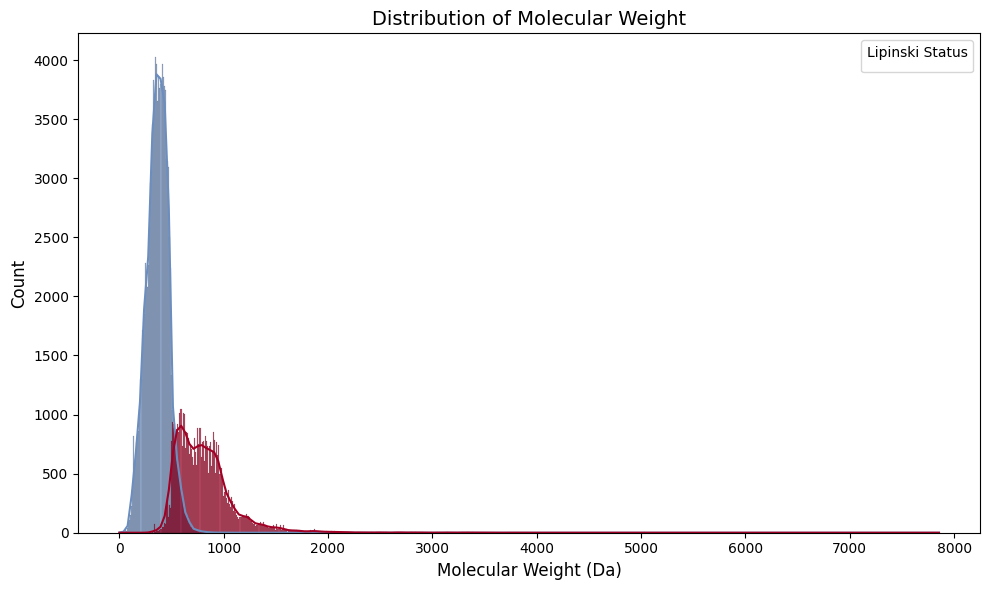

In [12]:
def visualize_property_distribution(df, property_col, hue_col='ro5_compliant',
                                   title=None, x_label=None, file_prefix=None):
    """
    Visualize the distribution of a molecular property.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    property_col : str
        Name of the property column to visualize
    hue_col : str
        Name of the column to use for coloring
    title : str
        Title for the plot
    x_label : str
        Label for the x-axis
    file_prefix : str
        Prefix for saved files

    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the plot
    """
    plt.figure(figsize=(10, 6))

    # Create the distribution plot
    ax = sns.histplot(
        data=df,
        x=property_col,
        hue=hue_col,
        multiple="layer",
        palette=["#A20025", "#6C8EBF"],
        alpha=0.7,
        kde=True
    )

    # Add title and labels
    if title:
        ax.set_title(title, fontsize=14)
    if x_label:
        ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

    # Add a legend with better labels
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ["Non-compliant", "RO5 Compliant"], title="Lipinski Status")

    plt.tight_layout()

    # Save the figure if requested
    if file_prefix:
        file_path = f"{file_prefix}_{property_col.lower()}.png"
        plt.savefig(file_path, bbox_inches='tight', dpi=600)
        pdf_path = f"{file_prefix}_{property_col.lower()}.pdf"
        plt.savefig(pdf_path, bbox_inches='tight', dpi=600)
        print(f"Figure saved to {file_path} and {pdf_path}")

    return plt.gcf()

# Visualize molecular weight distribution
mw_fig = visualize_property_distribution(
    specs,
    'ExactMolWt',
    title='Distribution of Molecular Weight',
    x_label='Molecular Weight (Da)',
    file_prefix='exactmolwt_dist'
)

Property comparison between RO5 compliant and non-compliant compounds:


,property,RO5 Compliant Mols,RO5 Violated Mols,rel_change
0,NumHAcceptors,4.791484,11.929556,-59.835183
1,NumHDonors,1.730129,5.587051,-69.033235
2,MolLogP,3.023400,6.008349,-49.680013


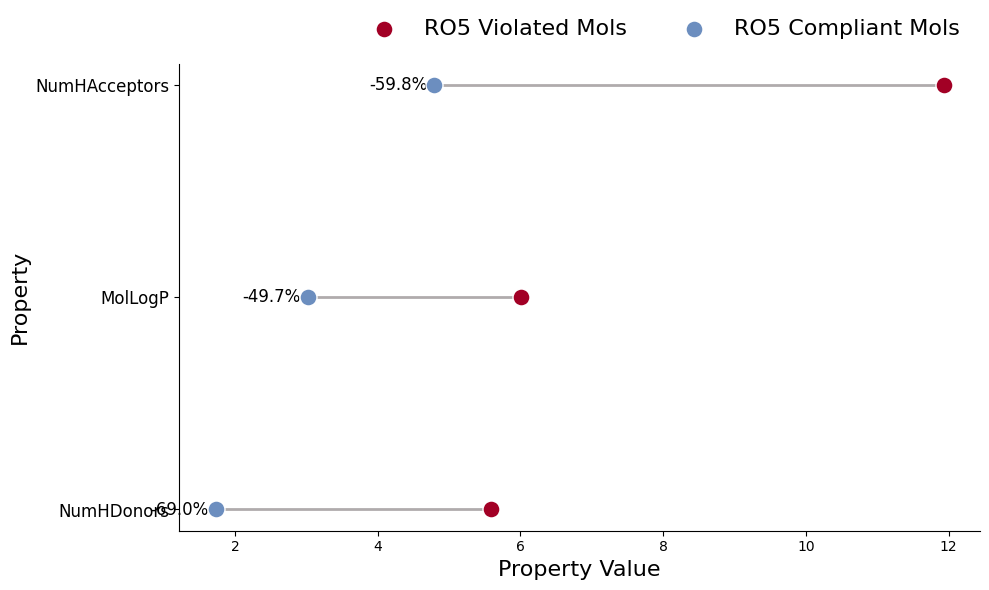

In [13]:
def compare_properties_between_groups(compliant_df, violated_df, properties):
    """
    Compare molecular properties between two groups.

    Parameters:
    -----------
    compliant_df : pandas.DataFrame
        DataFrame containing the first group
    violated_df : pandas.DataFrame
        DataFrame containing the second group
    properties : list
        List of property columns to compare

    Returns:
    --------
    pandas.DataFrame
        DataFrame with property differences
    """
    # Calculate mean values for each property in each group
    data = []

    for prop in properties:
        compliant_mean = compliant_df[prop].mean()
        violated_mean = violated_df[prop].mean()
        rel_change = (compliant_mean - violated_mean) / violated_mean * 100

        data.append({
            'property': prop,
            'RO5 Compliant Mols': compliant_mean,
            'RO5 Violated Mols': violated_mean,
            'rel_change': rel_change
        })

    # Create dataframe
    comparison_df = pd.DataFrame(data)
    return comparison_df

def visualize_property_differences(comparison_df):
    """
    Visualize the differences in properties between two groups.

    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame with property differences

    Returns:
    --------
    matplotlib.figure.Figure
        Figure containing the plot
    """
    # Sort by property values
    ordered_df = comparison_df.sort_values(by='RO5 Compliant Mols')
    my_range = range(1, len(ordered_df.index) + 1)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Draw horizontal lines connecting the points
    ax.hlines(
        y=my_range,
        xmin=ordered_df['RO5 Violated Mols'],
        xmax=ordered_df['RO5 Compliant Mols'],
        color='#B0ABAC',
        linewidth=2
    )

    # Add percentage change annotations
    for x, y, ann in zip(ordered_df['RO5 Compliant Mols'], my_range, ordered_df['rel_change']):
        if ann < 0:
            ax.text(x - 0.1, y, f'{ann:.1f}%', ha='right', va='center', fontsize=12)
        else:
            ax.text(x + 0.1, y, f'+{ann:.1f}%', ha='left', va='center', fontsize=12)

    # Plot data points
    ax.scatter(
        ordered_df['RO5 Violated Mols'], my_range,
        s=150, color='#A20025', label="RO5 Violated Mols",
        zorder=3, edgecolor='white', linewidth=1
    )
    ax.scatter(
        ordered_df['RO5 Compliant Mols'], my_range,
        s=150, color='#6C8EBF', label="RO5 Compliant Mols",
        zorder=3, edgecolor='white', linewidth=1
    )

    # Configure the plot
    ax.set_yticks(my_range)
    ax.set_yticklabels(ordered_df['property'], fontsize=12)
    ax.set_xlabel('Property Value', fontsize=16)
    ax.set_ylabel('Property', fontsize=16)
    #ax.set_title('Property Differences Between RO5 Compliant and Non-Compliant Molecules', fontsize=14)

    # Remove frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend
    ax.legend(ncol=2, bbox_to_anchor=(1., 1.01), loc="lower right", frameon=False, fontsize=16)

    plt.tight_layout()

    # Save the figure
    plt.savefig('relchange_ro5.png', bbox_inches='tight', dpi=600)
    plt.savefig('relchange_ro5.pdf', bbox_inches='tight', dpi=600)

    return fig

# Compare RO5 properties between compliant and non-compliant compounds
properties_to_compare = ['NumHAcceptors', 'NumHDonors', 'MolLogP']
comparison_df = compare_properties_between_groups(
    specs_ro5_compliant,
    specs_ro5_violated,
    properties_to_compare
)

# Display the comparison
print("Property comparison between RO5 compliant and non-compliant compounds:")
display(comparison_df)

# Visualize the differences
diff_fig = visualize_property_differences(comparison_df)

#### <b> <font color='#A20025'> Structure-based Filters

Beyond physicochemical property filters, compounds can also be screened based on their structural characteristics. Some chemical substructures are considered undesirable in drug discovery because they are associated with:

Chemical reactivity: Molecules that may be unstable or prone to unwanted reactions

Assay interference: Compounds capable of disrupting biological assays (commonly referred to as PAINS — Pan-Assay Interference Compounds), often producing false-positive results

Toxicity: Structural motifs linked to potentially harmful biological effects

In this step, we will apply three categories of structural filters:

* PAINS filters: Designed to eliminate pan-assay interference compounds that may generate misleading activity signals through nonspecific mechanisms.

* BRENK filters: Intended to remove molecules containing functional groups known to cause issues in medicinal chemistry or drug development.

In [14]:
def apply_pains_brenk_filters(df, mol_col='mol'):
    """
    Apply PAINS and BRENK filters to a set of molecules.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    mol_col : str
        Name of the column containing RDKit molecule objects

    Returns:
    --------
    pandas.DataFrame
        DataFrame with added filter compliance column
    """
    # Ensures we're working with a new DataFrame, not a view
    df_copy = df.copy()

    # Initialize the filter catalog
    print("Initializing PAINS and BRENK filters...")
    filter_params = FilterCatalog.FilterCatalogParams()
    filter_params.AddCatalog(filter_params.FilterCatalogs.PAINS)
    filter_params.AddCatalog(filter_params.FilterCatalogs.BRENK)
    catalog = FilterCatalog.FilterCatalog(filter_params)

    # Apply the filters (HasMatch returns True for problematic compounds)
    print("Applying filters to molecules...")
    df_copy.loc[:, 'PAINS_BRENK_match'] = df_copy[mol_col].apply(catalog.HasMatch)
    df_copy.loc[:, 'PAINS_BRENK_compliant'] = ~df_copy['PAINS_BRENK_match']

    # Filter the dataframe
    filtered_df = df_copy[df_copy['PAINS_BRENK_compliant']]

    # Report results
    print(f"Compounds before PAINS/BRENK filter: {len(df_copy)}")
    print(f"Compounds failing PAINS/BRENK filter: {len(df_copy) - len(filtered_df)}")
    print(f"Compounds after PAINS/BRENK filter: {len(filtered_df)}")
    print(f"Percentage of compounds passing the filter: {len(filtered_df) / len(df_copy) * 100:.1f}%")

    return df_copy, filtered_df

# Apply PAINS and BRENK filters to the RO5 compliant compounds
specs_ro5_compliant, specs_ro5_pains_brenk_compliant = apply_pains_brenk_filters(specs_ro5_compliant)



Initializing PAINS and BRENK filters...
Applying filters to molecules...
Compounds before PAINS/BRENK filter: 103153
Compounds failing PAINS/BRENK filter: 63813
Compounds after PAINS/BRENK filter: 39340
Percentage of compounds passing the filter: 38.1%


NameError: name 'Path' is not defined

In [19]:
# After computing RO5 and PAINS/BRENK filters, save the results
from pathlib import Path
import pickle
save_molecular_dataframe(specs_ro5_compliant, "specs_ro5_compliant", chapter=".")
save_molecular_dataframe(specs_ro5_pains_brenk_compliant, "specs_ro5_pains_brenk_compliant", chapter=".")

Saving dataframe with 103153 rows to artifacts/specs_ro5_compliant.pkl.gz...
Successfully saved dataframe (51.9 MB)
Saving dataframe with 39340 rows to artifacts/specs_ro5_pains_brenk_compliant.pkl.gz...
Successfully saved dataframe (19.3 MB)


'artifacts/specs_ro5_pains_brenk_compliant.pkl.gz'

## GLAXO
We'll apply the Glaxo Wellcome hard filters, which are a set of substructural filters developed to identify compounds with problematic functionalities. These filters were designed to flag compounds that might:
- React with proteins through electrophilic mechanisms
- Form reactive metabolites
- Cause toxicity through specific mechanisms
- Have poor stability or other undesirable properties

In [22]:
from rdkit.Chem import MolFromSmarts
from rdkit import Chem
from tqdm import tqdm

# Filtri Glaxo (GSK) come SMARTS
# Fonte: J. Med. Chem. 1999, 42, 1504
GLAXO_FILTERS = {
    'alkyl_halide'       : '[CX4][F,Cl,Br,I]',
    'michael_acceptor'   : '[CH2]=[CH][C,c,S,N]',
    'aldehyde'           : '[CX3H1](=O)',
    'acid_anhydride'     : '[CX3](=O)[OX2][CX3](=O)',
    'acyl_halide'        : '[CX3](=O)[F,Cl,Br,I]',
    'sulfonyl_halide'    : '[SX4](=O)(=O)[F,Cl]',
    'isocyanate'         : '[NX2]=[C]=[OX1]',
    'isothiocyanate'     : '[NX2]=[C]=[SX1]',
    'epoxide'            : '[OX2r3]',
    'aziridine'          : '[NX3r3]',
    'peroxide'           : '[OX2][OX2]',
    'disulfide'          : '[SX2][SX2]',
    'phosphorus_halide'  : '[PX4][F,Cl,Br,I]',
    'thiol'              : '[SX2H]',
    'nitroso'            : '[NX2]=[OX1]',
    'diazo'              : '[CH]=[N+]=[N-]',
    'quaternary_nitrogen': '[NX4+]',
}

def apply_glaxo_filter(df, smiles_col='SMILES', verbose=True):
    """
    Apply Glaxo structural filters via SMARTS patterns.
    """
    # Precompila i pattern
    patterns = {name: MolFromSmarts(smarts)
                for name, smarts in GLAXO_FILTERS.items()}

    passed = []
    failed = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Glaxo filter"):
        mol = Chem.MolFromSmiles(row[smiles_col])

        if mol is None:
            failed.append({**row.to_dict(), 'filter_reason': 'invalid_smiles'})
            continue

        hit = None
        for name, pattern in patterns.items():
            if mol.HasSubstructMatch(pattern):
                hit = name
                break

        if hit is None:
            passed.append(row.to_dict())
        else:
            failed.append({**row.to_dict(), 'filter_reason': hit})

    df_passed = pd.DataFrame(passed).reset_index(drop=True)
    df_failed = pd.DataFrame(failed).reset_index(drop=True)

    if verbose:
        print(f"\n--- Glaxo Filter ---")
        print(f"Input  : {len(df)}")
        print(f"Passed : {len(df_passed)} ({len(df_passed)/len(df)*100:.1f}%)")
        print(f"Removed: {len(df_failed)} ({len(df_failed)/len(df)*100:.1f}%)")
        if len(df_failed) > 0:
            print("\nTop reasons:")
            print(df_failed['filter_reason'].value_counts().head(10))

    return df_passed, df_failed

In [23]:
df_library_glaxo, df_library_removed = apply_glaxo_filter(specs_ro5_pains_brenk_compliant, smiles_col='SMILES')
df_library_glaxo.to_csv('data/coconut_glaxo_filtered.csv', index=False)

Glaxo filter: 100%|██████████| 39340/39340 [00:28<00:00, 1360.94it/s]



--- Glaxo Filter ---
Input  : 39340
Passed : 39212 (99.7%)
Removed: 128 (0.3%)

Top reasons:
filter_reason
michael_acceptor       99
nitroso                21
quaternary_nitrogen     4
aziridine               2
sulfonyl_halide         1
alkyl_halide            1
Name: count, dtype: int64


Let's summarize the results of our filtering process. This gives us an overview of how many compounds were removed at each step and what percentage of the original library remains after all filters have been applied

In [24]:
def print_filtering_summary():
    """Print a summary of the filtering process"""
    original_count = len(df_library)
    pains_brenk_count = len(specs_ro5_pains_brenk_compliant)
    final_count = len(df_library_glaxo)

    print("Filtering Summary:")
    print(f"Original compound library size: {original_count}")
    print(f"After Lipinski's RO5 and PAINS/BRENK filter: {pains_brenk_count} ({pains_brenk_count/original_count*100:.1f}%)")
    print(f"After Glaxo Wellcome filter: {final_count} ({final_count/original_count*100:.1f}%)")
    print(f"Total compounds removed: {original_count - final_count} ({(original_count - final_count)/original_count*100:.1f}%)")

# Print the filtering summary
print_filtering_summary()

Filtering Summary:
Original compound library size: 149999
After Lipinski's RO5 and PAINS/BRENK filter: 39340 (26.2%)
After Glaxo Wellcome filter: 39212 (26.1%)
Total compounds removed: 110787 (73.9%)


## <b> <font color='#A20025'> Fingerprints: Representing Molecules as Numbers

To perform a similarity search, we need to convert our molecules into numerical vectors called fingerprints. We will use Morgan fingerprints (also known as ECFP – Extended Connectivity Fingerprints).

In [25]:
def generate_morgan_fingerprints(df, mol_col='mol', radius=2, n_bits=2048):
    """
    Generate Morgan fingerprints for a set of molecules.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules
    mol_col : str
        Name of the column containing RDKit molecule objects
    radius : int
        Radius for the Morgan fingerprint algorithm
    n_bits : int
        Number of bits in the fingerprint

    Returns:
    --------
    pandas.DataFrame
        DataFrame with added fingerprint column
    """
    print(f"Generating Morgan fingerprints (radius={radius}, n_bits={n_bits})...")

    df_copy = df.copy()
    fp_col_name = f"morgan_fp_r{radius}_b{n_bits}"

    morgan_generator = GetMorganGenerator(radius=radius, fpSize=n_bits)

    def compute_fingerprint(mol):
        """Generate a Morgan fingerprint for a molecule"""
        if mol is None:
            return None
        return morgan_generator.GetFingerprint(mol)

    df_copy.loc[:,fp_col_name] = df_copy[mol_col].apply(compute_fingerprint)

    print(f"Fingerprints generated and stored in column '{fp_col_name}'")
    return df_copy, fp_col_name

# Generate fingerprints for our filtered compounds
specs_filtered, fp_col_name = generate_morgan_fingerprints(df_library_glaxo)


Generating Morgan fingerprints (radius=2, n_bits=2048)...
Fingerprints generated and stored in column 'morgan_fp_r2_b2048'


In [26]:
specs_filtered.head()

,COCONUT_ID,SMILES,mol,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP,ro5_violations,ro5_compliant,PAINS_BRENK_match,PAINS_BRENK_compliant,morgan_fp_r2_b2048
0,664263,CCOCC1=C2/C(=C\[C@@]3(C)CC[C@](O)(O3)[C@@](C)(...,<rdkit.Chem.rdchem.Mol object at 0x79f0dd868040>,382.162768,8,2,1.1043,0,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,848459,COCC(=O)N[C@H]1C[C@H]2C(=O)NC[C@@H](CCC(=O)N3C...,<rdkit.Chem.rdchem.Mol object at 0x79f0dd8680b0>,444.248504,7,2,-0.7857,0,True,False,True,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,389897,COC1=CC=C(CCNC(=O)CCC2=CN(C3=CC=CC=C3)N=C2C2=C...,<rdkit.Chem.rdchem.Mol object at 0x79f0e01ac190>,455.220892,4,1,4.8480,0,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,846445,CCC[C@@H](O)C[C@@H]1CCC[C@H](C[C@@H](O)CCC)N1C,<rdkit.Chem.rdchem.Mol object at 0x79f0e01ac4a0>,271.251129,3,2,2.9415,0,True,False,True,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,847065,COC1=CC([C@H]2OC[C@H]3[C@H]2CO[C@H]3C2=CC(OC)=...,<rdkit.Chem.rdchem.Mol object at 0x79f0e01ac430>,418.162768,8,2,3.2074,0,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Original Molecule:


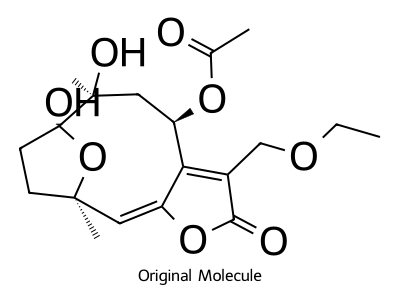


Showing 5 of 54 total fingerprint features:
Feature 1 (Bit 22):


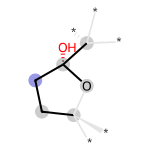

Feature 2 (Bit 76):


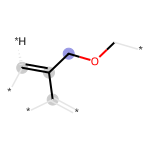

Feature 3 (Bit 80):


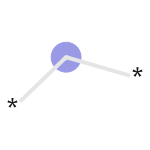

Feature 4 (Bit 291):


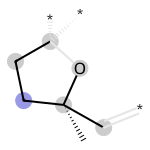

Feature 5 (Bit 294):


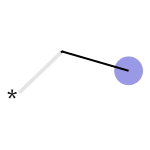

In [27]:
def visualize_fingerprint_decomposition(mol, n_features=5, radius=2):
    """
    Visualize the structural features that contribute to a molecule's fingerprint.

    Parameters:
    -----------
    mol : rdkit.Chem.rdchem.Mol
        RDKit molecule object
    n_features : int
        Number of fingerprint features to visualize
    radius : int
        Radius for the Morgan fingerprint

    Returns:
    --------
    list
        List of SVG images of the structural features
    """
    # Function to draw a fragment from a specific bit
    def draw_fragment_from_bit(mol, bit_number, bit_info):
        """Draw the fragment corresponding to a specific bit in the fingerprint"""
        try:
            svg = Draw.DrawMorganBit(mol, bit_number, bit_info, useSVG=True)
            return svg
        except Exception as e:
            print(f"Error drawing bit {bit_number}: {str(e)}")
            return None

    # First, draw the entire molecule
    mol_img = Draw.MolsToGridImage(
        mols=[mol],
        molsPerRow=1,
        subImgSize=(400, 300),
        useSVG=True,
        drawOptions=rdkit_drawing_options,
        legends=["Original Molecule"]
    )

    print("Original Molecule:")
    display(mol_img)

    # Save the original molecule image
    with open(f"./fp_decomposition_example_mol.svg", "w") as f:
        f.write(mol_img.data)

    # Generate the fingerprint and get bit info
    ao = AdditionalOutput()
    ao.AllocateBitInfoMap()
    morgan_generator = GetMorganGenerator(radius=radius, fpSize=2048)
    fp = morgan_generator.GetFingerprint(mol, additionalOutput=ao)

    # Get the indices of set bits
    set_bits = [idx for idx, bit in enumerate(fp) if bit]
    if not set_bits:
        print("No bits set in the fingerprint")
        return []

    # Limit to the requested number of features
    feature_bits = set_bits[:n_features]
    print(f"\nShowing {len(feature_bits)} of {len(set_bits)} total fingerprint features:")

    # Generate and display images for each feature
    bit_images = []
    for i, bit_idx in enumerate(feature_bits):
        bit_img = draw_fragment_from_bit(mol, bit_idx, ao.GetBitInfoMap())
        if bit_img:
            print(f"Feature {i+1} (Bit {bit_idx}):")
            display(bit_img)
            bit_images.append(bit_img)

            # Save the feature image
            with open(f"./fp_decomposition_bit{i}.svg", "w") as f:
                f.write(bit_img.data)

    return bit_images

# Visualize fingerprint decomposition for a sample molecule
example_mol = specs_filtered.mol.iloc[0]
feature_images = visualize_fingerprint_decomposition(example_mol, n_features=5)

## <b> <font color='#A20025'>  Similarity Searching

We compute the fingerprinting also for our reference dataset.

In [30]:
df_ref_actives = smiles_to_mol(df_ref_actives)


Building mol objects: 100%|██████████| 5605/5605 [00:03<00:00, 1742.42mol/s]

Valid molecules  : 5605
Invalid molecules: 0


In [31]:
df_ref_actives, df_ref_col = generate_morgan_fingerprints(df_ref_actives)

Generating Morgan fingerprints (radius=2, n_bits=2048)...
Fingerprints generated and stored in column 'morgan_fp_r2_b2048'


In [32]:
df_ref_actives.head()

,SMILES,IC50_nM,molecule_chembl_id,pIC50,active,mol,morgan_fp_r2_b2048
0,Brc1ccc(-c2nnc(N3CCN(c4ccccn4)CC3)o2)cc1,126.0,CHEMBL4779999,6.899629,1,<rdkit.Chem.rdchem.Mol object at 0x79f0e30f9000>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Brc1ccc(CNC2CCN(Cc3ccccc3)C2)cc1,648.0,CHEMBL4741398,6.188425,1,<rdkit.Chem.rdchem.Mol object at 0x79f0e30f8dd0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,C#CCCOc1cnc(C(=O)Nc2cccc([C@]3(C)CCSC(N)=N3)c2...,130.0,CHEMBL3640222,6.886057,1,<rdkit.Chem.rdchem.Mol object at 0x79f0e30f99a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,C#CCN(C)Cc1cc2cc(OCCCC3CCN(Cc4ccccc4)CC3)ccc2n1C,460.0,CHEMBL1929421,6.337242,1,<rdkit.Chem.rdchem.Mol object at 0x79f0e30f8d60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
4,C#CCNC[C@@H](O)[C@H](Cc1ccccc1)NC(=O)c1cc2c3c(...,95.5,CHEMBL562290,7.019997,1,<rdkit.Chem.rdchem.Mol object at 0x79f0e30f90e0>,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Compute similarity search

Selected Malaria Box compound #236 as query:


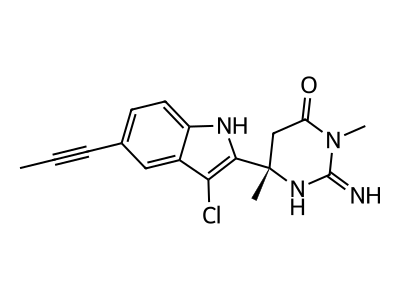


Computing similarity scores...
Similarity Score Statistics:

Tanimoto Similarity:
Min: 0.0000
Max: 0.2740
Mean: 0.0894
Median: 0.0886

Dice Similarity:
Min: 0.0000
Max: 0.4301
Mean: 0.1630
Median: 0.1628


In [34]:
def compute_similarity_to_query(query_fp, fp_list):
    """
    Compute similarity between a query fingerprint and a list of fingerprints.

    Parameters:
    -----------
    query_fp : rdkit.DataStructs._VectInt
        Query fingerprint
    fp_list : list
        List of fingerprints to compare against

    Returns:
    --------
    tuple
        Tanimoto and Dice similarity scores
    """
    tanimoto_sim = DataStructs.BulkTanimotoSimilarity(query_fp, fp_list)
    dice_sim = DataStructs.BulkDiceSimilarity(query_fp, fp_list)
    return tanimoto_sim, dice_sim

def analyze_similarity_scores(df, tanimoto_scores, dice_scores):
    """
    Analyze similarity scores distribution.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame to add scores to
    tanimoto_scores : list
        Tanimoto similarity scores
    dice_scores : list
        Dice similarity scores

    Returns:
    --------
    pandas.DataFrame
        DataFrame with added similarity scores
    """
    # Add scores to the dataframe
    df['tanimoto_sim'] = tanimoto_scores
    df['dice_sim'] = dice_scores

    # Basic statistics
    print("Similarity Score Statistics:")
    print("\nTanimoto Similarity:")
    print(f"Min: {min(tanimoto_scores):.4f}")
    print(f"Max: {max(tanimoto_scores):.4f}")
    print(f"Mean: {np.mean(tanimoto_scores):.4f}")
    print(f"Median: {np.median(tanimoto_scores):.4f}")

    print("\nDice Similarity:")
    print(f"Min: {min(dice_scores):.4f}")
    print(f"Max: {max(dice_scores):.4f}")
    print(f"Mean: {np.mean(dice_scores):.4f}")
    print(f"Median: {np.median(dice_scores):.4f}")

    return df

# Check if we have both datasets before proceeding
if 'df_ref_actives' in locals() and 'specs_filtered' in locals() and len(df_ref_actives) > 0:
    # Select a query molecule from the Malaria Box (index 236 as in the original script)
    query_idx = 236
    if query_idx < len(df_ref_actives):
        query_fp = df_ref_actives[df_ref_col].iloc[query_idx]
        query_mol = df_ref_actives.mol.iloc[query_idx]

        print(f"Selected Malaria Box compound #{query_idx} as query:")
        query_img = Draw.MolsToGridImage(
            mols=[query_mol],
            molsPerRow=1,
            subImgSize=(400, 300),
            useSVG=True,
            drawOptions=rdkit_drawing_options
        )
        display(query_img)

        # Save the query molecule image
        with open("example_bace1_mol.svg", "w") as f:
            f.write(query_img.data)

        # Get fingerprints from the filtered library
        library_fps = specs_filtered[fp_col_name].tolist()

        # Compute similarity scores
        print("\nComputing similarity scores...")
        tanimoto_scores, dice_scores = compute_similarity_to_query(query_fp, library_fps)

        # Analyze scores
        specs_filtered = analyze_similarity_scores(specs_filtered, tanimoto_scores, dice_scores)
    else:
        print(f"Query index {query_idx} is out of range for Malaria Box with {len(df_ref_actives)} compounds")
else:
    print("Similarity searching cannot proceed without both datasets")

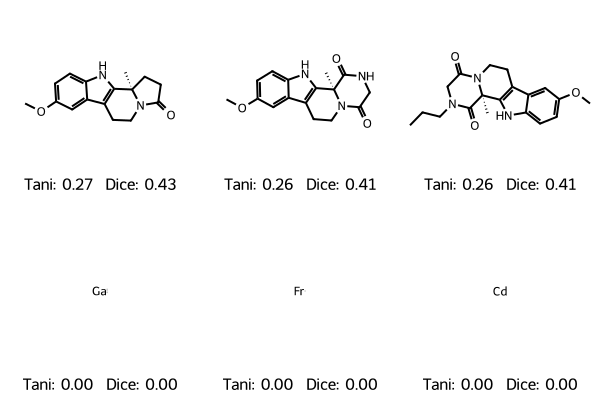

Similarity visualization saved to 'example_tani_dice_sim.svg'


<Figure size 640x480 with 0 Axes>

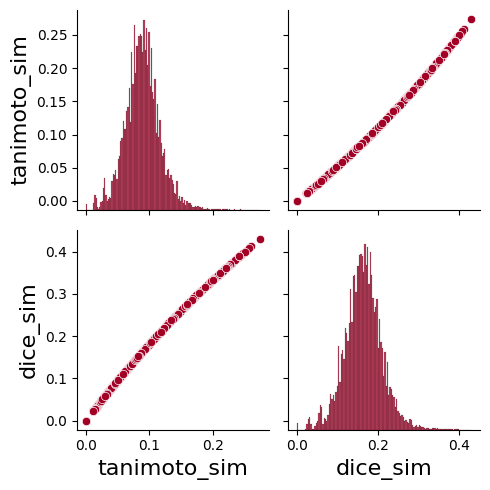

In [35]:
def visualize_similarity_extremes(df, sim_col, sim_col_2=None, n=3):
    """
    Visualize molecules with highest and lowest similarity scores.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing molecules and similarity scores
    sim_col : str
        Name of the similarity score column
    sim_col_2 : str
        Name of a second similarity score column (optional)
    n : int
        Number of molecules to show from each extreme

    Returns:
    --------
    rdkit.Chem.Draw._MolsToGridImage
        Grid image of molecules
    """
    # Order by similarity
    df_ordered = df.sort_values([sim_col], ascending=False).reset_index(drop=True)

    # Get highest and lowest similarity molecules
    extremes = pd.concat([df_ordered[:n], df_ordered.dropna()[-n:]])

    # Create legends
    if sim_col_2:
        legend_text = [f"Tani: {x:.2f}\tDice: {y:.2f}" for x, y in
                      zip(extremes[sim_col], extremes[sim_col_2])]
    else:
        legend_text = [f"{x:.2f}" for x in extremes[sim_col]]

    # Create the visualization
    img = Draw.MolsToGridImage(
        extremes.mol,
        molsPerRow=n,
        legends=legend_text,
        useSVG=True,
        drawOptions=rdkit_drawing_options
    )

    return img

# Visualize similarity extremes if we have similarity scores
if 'specs_filtered' in locals() and 'tanimoto_sim' in specs_filtered.columns:
    sim_img = visualize_similarity_extremes(
        specs_filtered,
        sim_col="tanimoto_sim",
        sim_col_2="dice_sim",
        n=3
    )
    display(sim_img)

    # Save the visualization
    with open("example_tani_dice_sim.svg", "w") as f:
        f.write(sim_img.data)
    print("Similarity visualization saved to 'example_tani_dice_sim.svg'")

    # Visualize the relationship between Tanimoto and Dice similarity
    plt.figure()
    sns.pairplot(specs_filtered[["tanimoto_sim", "dice_sim"]])

    plt.tight_layout()

    # Save the figure
    plt.savefig('sim_pairplot.png', bbox_inches='tight', dpi=600)
    plt.savefig('sim_pairplot.pdf', bbox_inches='tight', dpi=600)


In [39]:
specs_filtered.head()

,COCONUT_ID,SMILES,mol,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP,ro5_violations,ro5_compliant,PAINS_BRENK_match,PAINS_BRENK_compliant,morgan_fp_r2_b2048,tanimoto_sim,dice_sim
0,664263,CCOCC1=C2/C(=C\[C@@]3(C)CC[C@](O)(O3)[C@@](C)(...,<rdkit.Chem.rdchem.Mol object at 0x79f0dd868040>,382.162768,8,2,1.1043,0,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.083333,0.153846
1,848459,COCC(=O)N[C@H]1C[C@H]2C(=O)NC[C@@H](CCC(=O)N3C...,<rdkit.Chem.rdchem.Mol object at 0x79f0dd8680b0>,444.248504,7,2,-0.7857,0,True,False,True,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0.095238,0.173913
2,389897,COC1=CC=C(CCNC(=O)CCC2=CN(C3=CC=CC=C3)N=C2C2=C...,<rdkit.Chem.rdchem.Mol object at 0x79f0e01ac190>,455.220892,4,1,4.8480,0,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.083333,0.153846
3,846445,CCC[C@@H](O)C[C@@H]1CCC[C@H](C[C@@H](O)CCC)N1C,<rdkit.Chem.rdchem.Mol object at 0x79f0e01ac4a0>,271.251129,3,2,2.9415,0,True,False,True,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.056338,0.106667
4,847065,COC1=CC([C@H]2OC[C@H]3[C@H]2CO[C@H]3C2=CC(OC)=...,<rdkit.Chem.rdchem.Mol object at 0x79f0e01ac430>,418.162768,8,2,3.2074,0,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.083333,0.153846


### FULL LIBRARY SEARCH

Searching for compounds with dice similarity ≥ 0.65...
Comparing 5605 query compounds against 39212 library compounds
Progress: 560/5605 queries processed (10.0%)
Progress: 1120/5605 queries processed (20.0%)
Progress: 1680/5605 queries processed (30.0%)
Progress: 2240/5605 queries processed (40.0%)
Progress: 2800/5605 queries processed (50.0%)
Progress: 3360/5605 queries processed (59.9%)
Progress: 3920/5605 queries processed (69.9%)
Progress: 4480/5605 queries processed (79.9%)
Progress: 5040/5605 queries processed (89.9%)
Progress: 5600/5605 queries processed (99.9%)
Progress: 5605/5605 queries processed (100.0%)
Found 163 compounds with similarity ≥ 0.65
Selected top 163 compounds (budget: 1000)

Hit Statistics:
Mean similarity: 0.7196
Median similarity: 0.6944
Min similarity: 0.6500
Max similarity: 1.0000

Saved 163 hits to ./specs_hits_to_BACE1.csv

Visualizing top 6 hits:


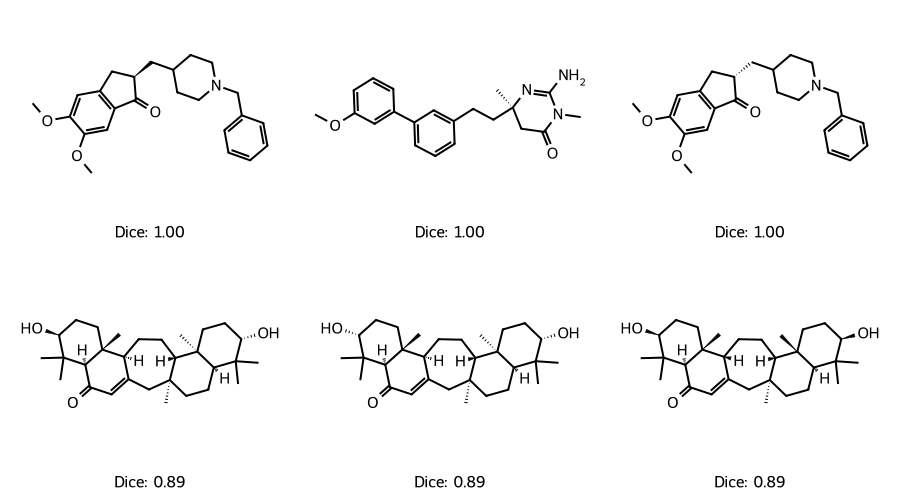

In [40]:
def search_similar_compounds(query_fps, library_fps, similarity_threshold=0.65):
    """
    Find compounds in a library that are similar to any query compound.

    Parameters:
    -----------
    query_fps : list
        List of query fingerprints
    library_fps : list
        List of library fingerprints
    similarity_threshold : float
        Minimum similarity score to consider

    Returns:
    --------
    dict
        Dictionary mapping library compound indices to their maximum similarity score
    """
    from collections import defaultdict

    # Initialize matches dictionary with default value 0
    matches = defaultdict(int)

    print(f"Searching for compounds with dice similarity ≥ {similarity_threshold}...")
    print(f"Comparing {len(query_fps)} query compounds against {len(library_fps)} library compounds")

    # Progress counter
    counter = 0
    update_frequency = max(1, len(query_fps) // 10)

    # Compare each query against the library
    for query_fp in query_fps:
        # Compute Dice similarity
        dice_sim = DataStructs.BulkDiceSimilarity(query_fp, library_fps)

        # Update matches with maximum similarity for each library compound
        for idx, sim in enumerate(dice_sim):
            if sim >= similarity_threshold:
                matches[idx] = max(sim, matches[idx])

        # Update progress
        counter += 1
        if counter % update_frequency == 0 or counter == len(query_fps):
            print(f"Progress: {counter}/{len(query_fps)} queries processed "
                  f"({counter/len(query_fps)*100:.1f}%)")

    print(f"Found {len(matches)} compounds with similarity ≥ {similarity_threshold}")
    return matches

def select_top_matches(matches, budget=1000):
    """
    Select the top matches up to a budget constraint.

    Parameters:
    -----------
    matches : dict
        Dictionary mapping compound indices to similarity scores
    budget : int
        Maximum number of compounds to select

    Returns:
    --------
    list
        Indices of the top compounds
    """
    import heapq

    # Convert to a list of (similarity, index) tuples
    heap = []
    for idx, sim in matches.items():
        # Use negative similarity for max-heap (Python has min-heap by default)
        heapq.heappush(heap, (-1 * sim, idx))

    # Pop top matches up to budget
    top_matches = []
    for i in range(min(budget, len(heap))):
        neg_sim, idx = heapq.heappop(heap)
        sim = -1 * neg_sim  # Convert back to positive similarity
        top_matches.append((idx, sim))

    print(f"Selected top {len(top_matches)} compounds (budget: {budget})")
    return top_matches

# Check if we have both datasets before proceeding
if 'df_ref_actives' in locals() and 'specs_filtered' in locals() and len(df_ref_actives) > 0:
    # Get fingerprints
    query_fps = df_ref_actives[df_ref_col].tolist()
    library_fps = specs_filtered[fp_col_name].tolist()

    # Search for similar compounds
    matches = search_similar_compounds(query_fps, library_fps, similarity_threshold=0.65)

    # Select top matches
    top_matches = select_top_matches(matches, budget=1000)

    if top_matches:
        # Extract hits
        hit_indices = [idx for idx, sim in top_matches]
        hit_similarities = [sim for idx, sim in top_matches]

        specs_hits = specs_filtered.iloc[hit_indices].copy()
        specs_hits['max_dice_sim'] = hit_similarities

        # Display statistics about the hits
        print("\nHit Statistics:")
        print(f"Mean similarity: {np.mean(hit_similarities):.4f}")
        print(f"Median similarity: {np.median(hit_similarities):.4f}")
        print(f"Min similarity: {min(hit_similarities):.4f}")
        print(f"Max similarity: {max(hit_similarities):.4f}")

        # Save the hits
        output_file = "./specs_hits_to_BACE1.csv"
        specs_hits.to_csv(
            output_file,
            columns=["COCONUT_ID", "SMILES", "max_dice_sim"],
            index=False
        )
        print(f"\nSaved {len(specs_hits)} hits to {output_file}")

        # Visualize a few top hits
        top_n = 6
        if len(specs_hits) >= top_n:
            print(f"\nVisualizing top {top_n} hits:")
            top_hits = specs_hits.sort_values('max_dice_sim', ascending=False).head(top_n)

            hits_img = Draw.MolsToGridImage(
                top_hits.mol,
                molsPerRow=3,
                subImgSize=(300, 250),
                legends=[f"Dice: {sim:.2f}" for sim in top_hits.max_dice_sim],
                useSVG=True,
                drawOptions=rdkit_drawing_options
            )
            display(hits_img)
    else:
        print("No hits found meeting the similarity threshold")
else:
    print("Similarity searching cannot proceed without both datasets")

We repeat now the whole similarity search using Tanimoto distance.

Searching for compounds with Tanimoto similarity ≥ 0.65...
Comparing 5605 query compounds against 39212 library compounds
Progress: 560/5605 queries processed (10.0%)
Progress: 1120/5605 queries processed (20.0%)
Progress: 1680/5605 queries processed (30.0%)
Progress: 2240/5605 queries processed (40.0%)
Progress: 2800/5605 queries processed (50.0%)
Progress: 3360/5605 queries processed (59.9%)
Progress: 3920/5605 queries processed (69.9%)
Progress: 4480/5605 queries processed (79.9%)
Progress: 5040/5605 queries processed (89.9%)
Progress: 5600/5605 queries processed (99.9%)
Progress: 5605/5605 queries processed (100.0%)
Found 26 compounds with Tanimoto similarity ≥ 0.65
Selected top 26 compounds (budget: 1000)

Hit Statistics (Tanimoto):
Mean similarity  : 0.7540
Median similarity: 0.7188
Min similarity   : 0.6538
Max similarity   : 1.0000

Saved 26 hits to ./specs_hits_to_BACE1_tanimoto.csv

Visualizing top 6 hits:


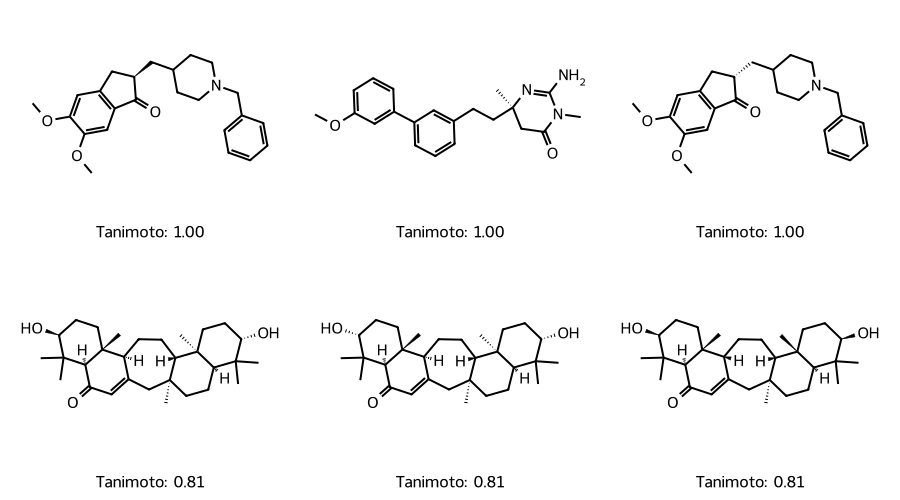

In [41]:
def search_similar_compounds_tanimoto(query_fps, library_fps, similarity_threshold=0.65):
    from collections import defaultdict

    matches = defaultdict(int)

    print(f"Searching for compounds with Tanimoto similarity ≥ {similarity_threshold}...")
    print(f"Comparing {len(query_fps)} query compounds against {len(library_fps)} library compounds")

    counter = 0
    update_frequency = max(1, len(query_fps) // 10)

    for query_fp in query_fps:

        tanimoto_sim = DataStructs.BulkTanimotoSimilarity(query_fp, library_fps)

        for idx, sim in enumerate(tanimoto_sim):
            if sim >= similarity_threshold:
                matches[idx] = max(sim, matches[idx])

        counter += 1
        if counter % update_frequency == 0 or counter == len(query_fps):
            print(f"Progress: {counter}/{len(query_fps)} queries processed "
                  f"({counter/len(query_fps)*100:.1f}%)")

    print(f"Found {len(matches)} compounds with Tanimoto similarity ≥ {similarity_threshold}")
    return matches



if 'df_ref_actives' in locals() and 'specs_filtered' in locals() and len(df_ref_actives) > 0:
    query_fps   = df_ref_actives[df_ref_col].tolist()
    library_fps = specs_filtered[fp_col_name].tolist()

    matches_tanimoto = search_similar_compounds_tanimoto(query_fps, library_fps, similarity_threshold=0.65)
    top_matches_tanimoto = select_top_matches(matches_tanimoto, budget=1000)

    if top_matches_tanimoto:
        hit_indices     = [idx for idx, sim in top_matches_tanimoto]
        hit_similarities = [sim for idx, sim in top_matches_tanimoto]

        specs_hits_tanimoto = specs_filtered.iloc[hit_indices].copy()
        specs_hits_tanimoto['max_tanimoto_sim'] = hit_similarities

        print("\nHit Statistics (Tanimoto):")
        print(f"Mean similarity  : {np.mean(hit_similarities):.4f}")
        print(f"Median similarity: {np.median(hit_similarities):.4f}")
        print(f"Min similarity   : {min(hit_similarities):.4f}")
        print(f"Max similarity   : {max(hit_similarities):.4f}")


        output_file = "./specs_hits_to_BACE1_tanimoto.csv"
        specs_hits_tanimoto.to_csv(
            output_file,
            columns=["COCONUT_ID", "SMILES", "max_tanimoto_sim"],
            index=False
        )
        print(f"\nSaved {len(specs_hits_tanimoto)} hits to {output_file}")


        top_n = 6
        if len(specs_hits_tanimoto) >= top_n:
            print(f"\nVisualizing top {top_n} hits:")
            top_hits = specs_hits_tanimoto.sort_values('max_tanimoto_sim', ascending=False).head(top_n)
            hits_img = Draw.MolsToGridImage(
                top_hits.mol,
                molsPerRow=3,
                subImgSize=(300, 250),
                legends=[f"Tanimoto: {sim:.2f}" for sim in top_hits.max_tanimoto_sim],
                useSVG=True,
                drawOptions=rdkit_drawing_options
            )
            display(hits_img)

,COCONUT_ID,SMILES,mol,ExactMolWt,NumHAcceptors,NumHDonors,MolLogP,ro5_violations,ro5_compliant,PAINS_BRENK_match,PAINS_BRENK_compliant,morgan_fp_r2_b2048,tanimoto_sim,dice_sim,max_tanimoto_sim
1512,744648,COC1=CC2=C(C=C1OC)C(=O)[C@H](CC1CCN(CC3=CC=CC=...,<rdkit.Chem.rdchem.Mol object at 0x79f0e0d1bd80>,379.214744,4,0,4.3611,0,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.141176,0.247423,1.000000
3580,940235,COC1=CC=CC(C2=CC=CC(CC[C@]3(C)CC(=O)N(C)C(N)=N...,<rdkit.Chem.rdchem.Mol object at 0x79f0dd5ce570>,351.194677,4,1,3.2303,0,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.192771,0.323232,1.000000
19719,893211,COC1=CC2=C(C=C1OC)C(=O)[C@@H](CC1CCN(CC3=CC=CC...,<rdkit.Chem.rdchem.Mol object at 0x79f0df588cf0>,379.214744,4,0,4.3611,0,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.141176,0.247423,1.000000
4997,782245,CC1(C)[C@H]2CC[C@@]3(C)CC4=CC(=O)[C@H]5C(C)(C)...,<rdkit.Chem.rdchem.Mol object at 0x79f0dd724d60>,456.360345,3,2,6.3187,1,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.105882,0.191489,0.807692
12322,691632,CC1(C)[C@H]2CC[C@@]3(C)CC4=CC(=O)[C@H]5C(C)(C)...,<rdkit.Chem.rdchem.Mol object at 0x79f0e0b95fc0>,456.360345,3,2,6.3187,1,True,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.105882,0.191489,0.807692


## Compare results

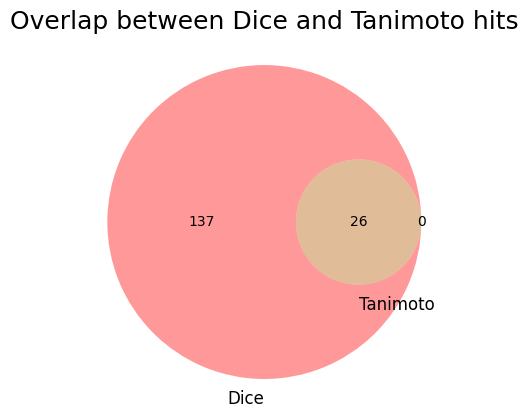

In [43]:
import pandas as pd
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

dice_df = pd.read_csv("specs_hits_to_BACE1.csv")
tani_df = pd.read_csv("specs_hits_to_BACE1_tanimoto.csv")

dice_set = set(dice_df["COCONUT_ID"])
tani_set = set(tani_df["COCONUT_ID"])

plt.figure()
venn2([dice_set, tani_set], set_labels=("Dice", "Tanimoto"))
plt.title("Overlap between Dice and Tanimoto hits")
plt.show()

# Descriptors and drug-likeness

QED (Quantitative Estimate of Drug-likeness) is a numerical score that estimates how “drug-like” a molecule is.

It combines several physicochemical properties — such as molecular weight, lipophilicity (logP), hydrogen bond donors and acceptors, polar surface area, and others — into a single value between 0 and 1.

Values close to 1 indicate high drug-likeness

Values close to 0 indicate poor drug-like characteristics

In [55]:
from rdkit.Chem import QED
specs_hits["QED"] = specs_hits["mol"].apply(QED.qed)
specs_hits_tanimoto["QED"] = specs_hits_tanimoto["mol"].apply(QED.qed)

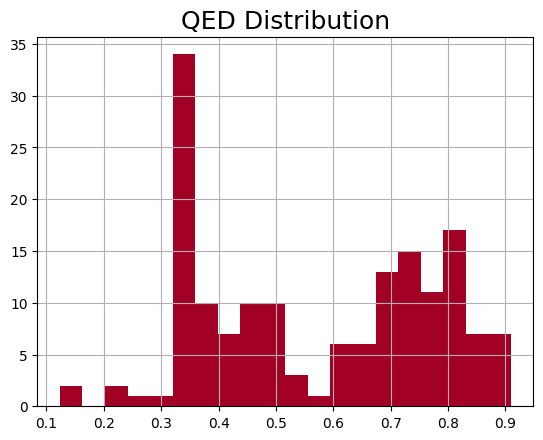

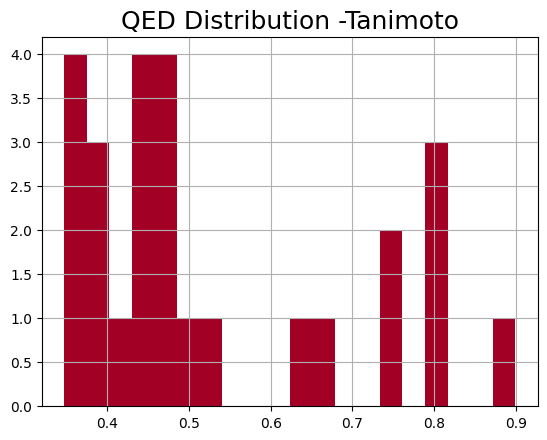

In [56]:
specs_hits["QED"].hist(bins=20)
plt.title("QED Distribution")
plt.show()


specs_hits_tanimoto["QED"].hist(bins=20)
plt.title("QED Distribution -Tanimoto")
plt.show()

In [52]:
specs_hits.columns

Index(['COCONUT_ID', 'SMILES', 'mol', 'ExactMolWt', 'NumHAcceptors',
       'NumHDonors', 'MolLogP', 'ro5_violations', 'ro5_compliant',
       'PAINS_BRENK_match', 'PAINS_BRENK_compliant', 'morgan_fp_r2_b2048',
       'tanimoto_sim', 'dice_sim', 'max_dice_sim', 'QED'],
      dtype='object')

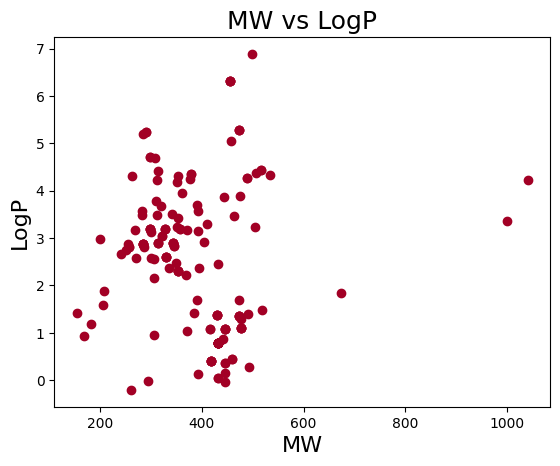

In [53]:
plt.scatter(specs_hits["ExactMolWt"], specs_hits["MolLogP"])
plt.xlabel("MW")
plt.ylabel("LogP")
plt.title("MW vs LogP")
plt.show()

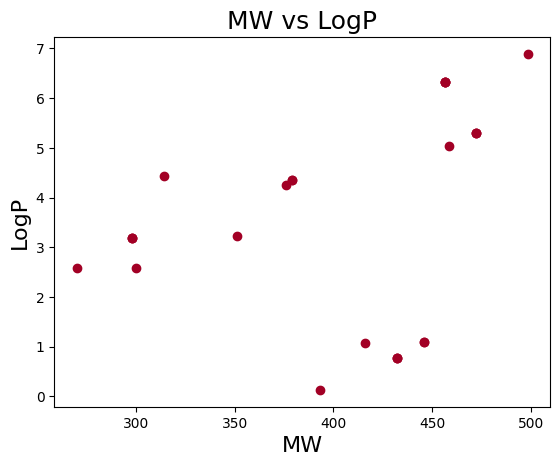

In [57]:
plt.scatter(specs_hits_tanimoto["ExactMolWt"], specs_hits_tanimoto["MolLogP"])
plt.xlabel("MW")
plt.ylabel("LogP")
plt.title("MW vs LogP")
plt.show()

In [58]:
#

Index(['COCONUT_ID', 'SMILES', 'mol', 'ExactMolWt', 'NumHAcceptors',
       'NumHDonors', 'MolLogP', 'ro5_violations', 'ro5_compliant',
       'PAINS_BRENK_match', 'PAINS_BRENK_compliant', 'morgan_fp_r2_b2048',
       'tanimoto_sim', 'dice_sim', 'max_dice_sim', 'QED'],
      dtype='object')

In [59]:
## Source Organism


full_coconut = pd.read_csv("data/coconut_csv/coconut_csv_lite-02-2026.csv")



In [64]:
full_coconut.head()

,id,identifier,canonical_smiles,standard_inchi,standard_inchi_key,name,iupac_name,annotation_level,total_atom_count,heavy_atom_count,...,murcko_framework,np_likeness,chemical_class,chemical_sub_class,chemical_super_class,direct_parent_classification,np_classifier_pathway,np_classifier_superclass,np_classifier_class,np_classifier_is_glycoside
0,664263,CNP0298191.2,CCOCC1=C2/C(=C\[C@@]3(C)CC[C@](O)(O3)[C@@](C)(...,InChI=1S/C19H26O8/c1-5-24-10-12-15-13(26-16(12...,HODSXGNLSBTPSP-PZFOHEMESA-N,NaN,"[(1~{R},2~{E},8~{R},10~{S},11~{S})-6-(ethoxyme...",2,53,27,...,O1C2=CC3OC(CCCC2=CC1)CC3,2.43,Dihydrofurans,Furanones,Organoheterocyclic compounds,Butenolides,Terpenoids,Sesquiterpenoids,Germacrane sesquiterpenoids,True
1,848459,CNP0012362.1,COCC(=O)N[C@H]1C[C@H]2C(=O)NC[C@@H](CCC(=O)N3C...,InChI=1S/C22H32N6O4/c1-32-15-20(29)25-16-12-18...,FANMSXCPHJJQCQ-KSZLIROESA-N,NCGC00392657-01,"~{N}-[(4~{R},7~{S},8~{a}~{S})-1-oxo-4-[3-oxo-3...",2,64,32,...,n1ccccc1N2CCN(CC2)CCCC3N4CCCC4CNC3,-1.64,Diazinanes,Piperazines,Organoheterocyclic compounds,Pyridinylpiperazines,Alkaloids,NaN,NaN,False
2,389897,CNP0605579.0,COC1=CC=C(CCNC(=O)CCC2=CN(C3=CC=CC=C3)N=C2C2=C...,InChI=1S/C28H29N3O3/c1-33-25-15-13-21(19-26(25...,YQGDFVKRFFMGBX-UHFFFAOYSA-N,"N-[2-(3,4-dimethoxyphenyl)ethyl]-3-(1,3-diphen...","~{N}-[2-(3,4-dimethoxyphenyl)ethyl]-3-(1,3-dip...",3,63,34,...,n1c(-c2ccccc2)c(cn1-c3ccccc3)CCCNCCc4ccccc4,-1.14,Azoles,Pyrazoles,Organoheterocyclic compounds,Phenylpyrazoles,Alkaloids,NaN,NaN,False
3,664789,CNP0596552.1,CCC[C@H]1/N=C(\O)C2=CSC(=N2)[C@H](C)/N=C(\O)[C...,InChI=1S/C30H49N5O6S/c1-11-13-20-18(8)30(40)41...,LOMSNBSLWHBACM-LNJFAXJLSA-N,"(2~{S},3~{Z},5~{S},8~{S},9~{E},11~{S},14~{S},1...","(2~{S},3~{Z},5~{S},8~{S},9~{E},11~{S},14~{S},1...",3,91,42,...,N1=Cc2nc(sc2)CN=CCNCCN=CCOCCC1,0.59,Carboxylic acids and derivatives,"Amino acids, peptides, and analogues",Organic acids and derivatives,Alpha amino acids,Amino acids and Peptides,Oligopeptides,Cyclic peptides,False
4,255867,CNP0524350.0,COC1=CC(C=O)=CC=C1OC(=O)C1=CC=CC=C1Cl,InChI=1S/C15H11ClO4/c1-19-14-8-10(9-17)6-7-13(...,PXMDYNSNBXIDHA-UHFFFAOYSA-N,4-formyl-2-methoxyphenyl 2-chlorobenzoate,(4-formyl-2-methoxy-phenyl) 2-chlorobenzoate,3,31,20,...,O(c1ccccc1)Cc2ccccc2,-0.58,Depsides and depsidones,Depsides and depsidones,Phenylpropanoids and polyketides,Depsides and depsidones,NaN,NaN,NaN,False


In [65]:
full_DICE=full_coconut[full_coconut.id.isin(specs_hits.COCONUT_ID)].copy()
full_TANIMOTO=full_coconut[full_coconut.id.isin(specs_hits_tanimoto.COCONUT_ID)].copy()

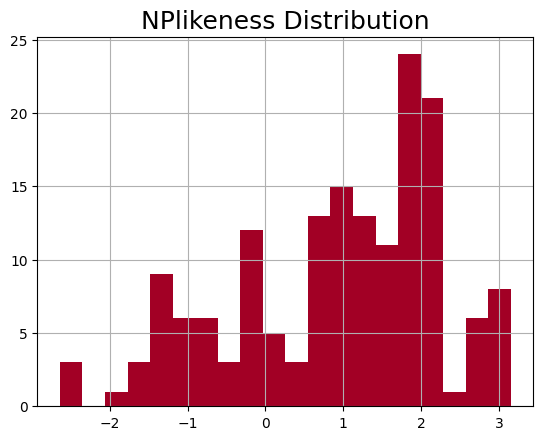

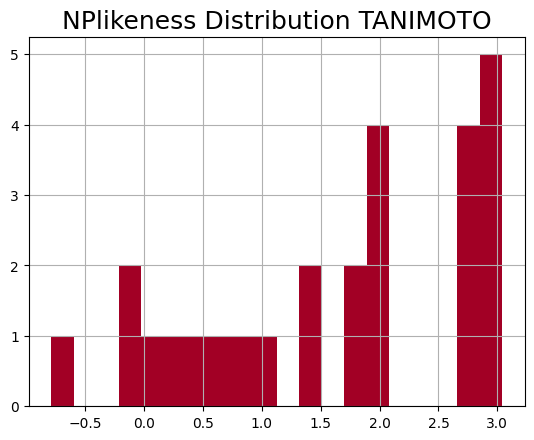

In [76]:
full_DICE.np_likeness.hist(bins=20)
plt.title("NPlikeness Distribution")
plt.show()

full_TANIMOTO.np_likeness.hist(bins=20)
plt.title("NPlikeness Distribution TANIMOTO")
plt.show()

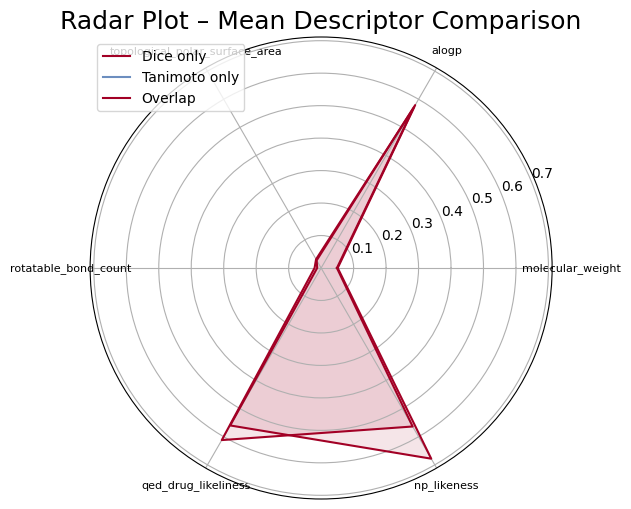

In [67]:
dice_set = set(dice_df["COCONUT_ID"])
tani_set = set(tani_df["COCONUT_ID"])

overlap_ids = dice_set & tani_set
dice_only_ids = dice_set - tani_set
tani_only_ids = tani_set - dice_set

overlap_df = full_coconut[full_coconut["id"].isin(overlap_ids)]
dice_only_df = full_coconut[full_coconut["id"].isin(dice_only_ids)]
tani_only_df = full_coconut[full_coconut["id"].isin(tani_only_ids)]
descriptors = [
    "molecular_weight",
    "alogp",
    "topological_polar_surface_area",
    "rotatable_bond_count",
    "qed_drug_likeliness",
    "np_likeness"
]
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

groups = {
    "Dice only": dice_only_df,
    "Tanimoto only": tani_only_df,
    "Overlap": overlap_df
}

# Normalizzazione globale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(full_coconut[descriptors])
scaled_df = full_coconut.copy()
scaled_df[descriptors] = scaled_data

# Calcolo medie
means = {}
for name, group in groups.items():
    scaled_group = scaled_df[scaled_df["identifier"].isin(group["identifier"])]
    means[name] = scaled_group[descriptors].mean().values

labels = descriptors
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

for name, values in means.items():
    values = np.concatenate((values, [values[0]]))
    ax.plot(angles, values, label=name)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=8)
plt.legend()
plt.title("Radar Plot – Mean Descriptor Comparison")
plt.show()



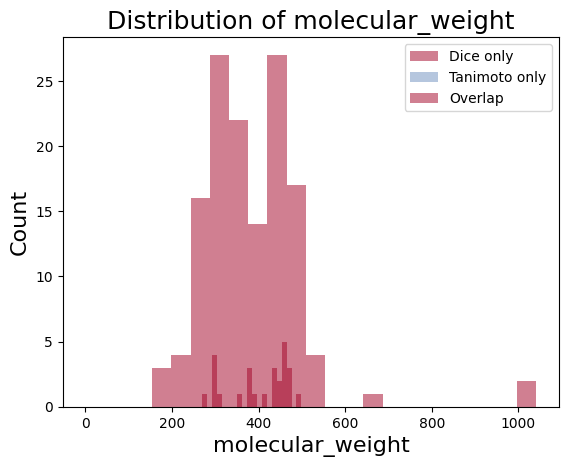

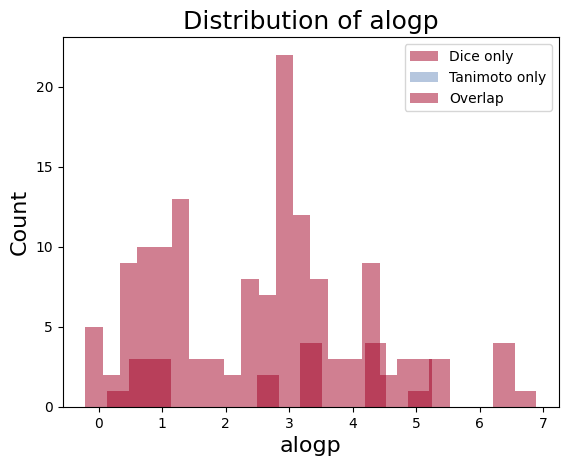

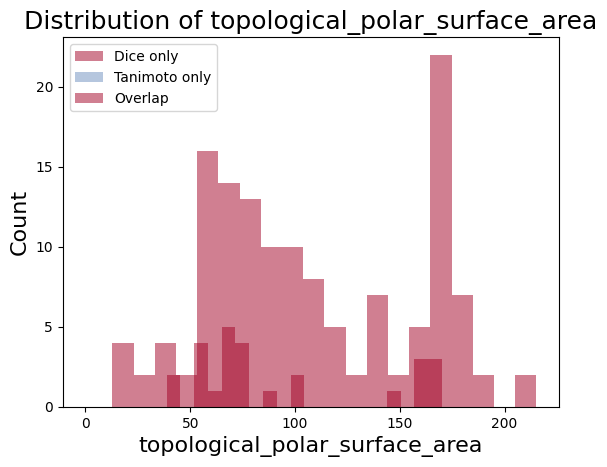

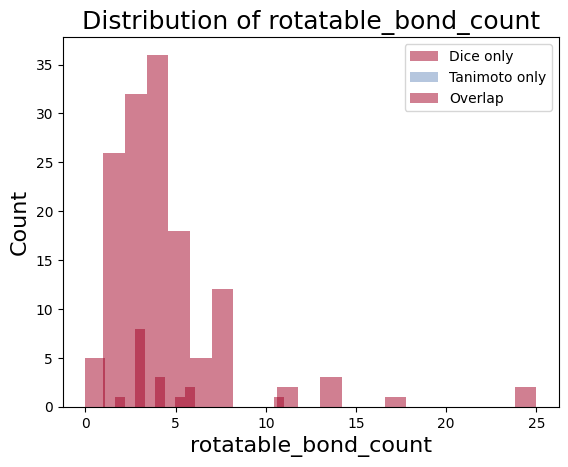

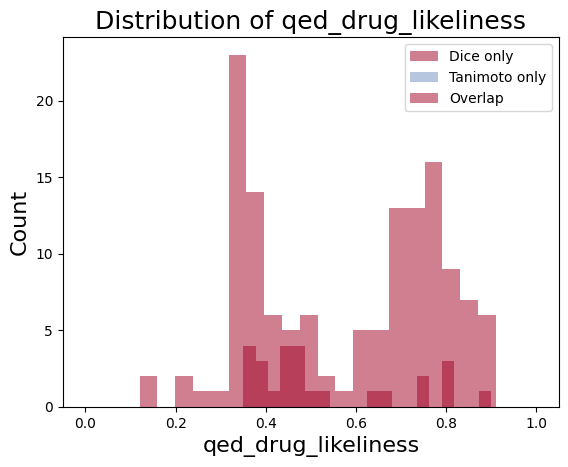

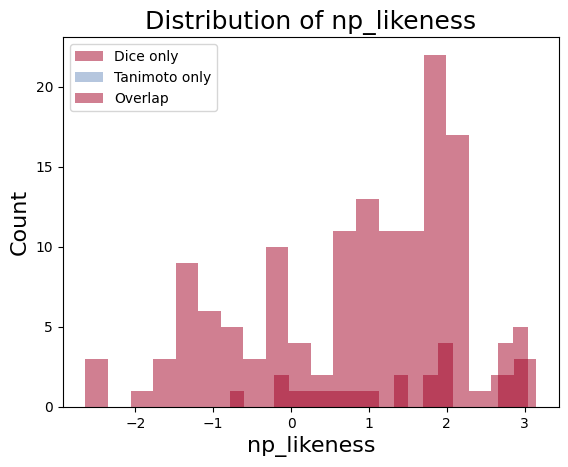

In [68]:
for desc in descriptors:
    plt.figure()
    plt.hist(dice_only_df[desc], bins=20, alpha=0.5, label="Dice only")
    plt.hist(tani_only_df[desc], bins=20, alpha=0.5, label="Tanimoto only")
    plt.hist(overlap_df[desc], bins=20, alpha=0.5, label="Overlap")
    plt.xlabel(desc)
    plt.ylabel("Count")
    plt.legend()
    plt.title(f"Distribution of {desc}")
    plt.show()


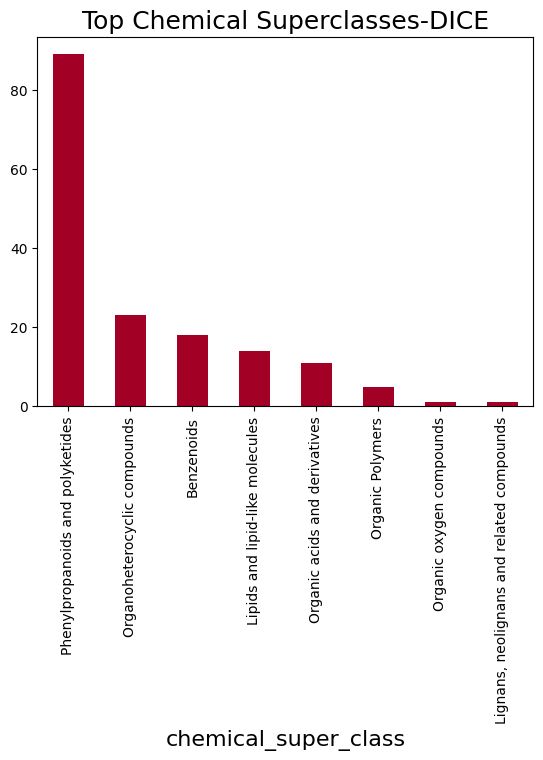

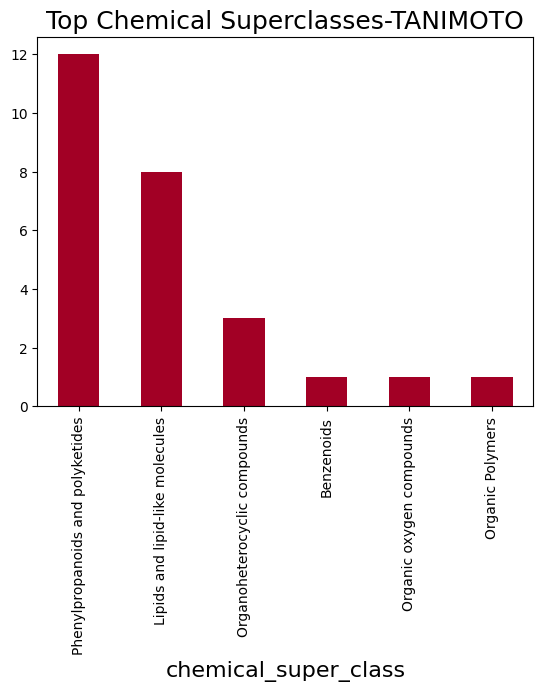

In [69]:
full_DICE["chemical_super_class"].value_counts().head(10).plot(kind="bar")
plt.title("Top Chemical Superclasses-DICE")
plt.show()


full_TANIMOTO["chemical_super_class"].value_counts().head(10).plot(kind="bar")
plt.title("Top Chemical Superclasses-TANIMOTO")
plt.show()

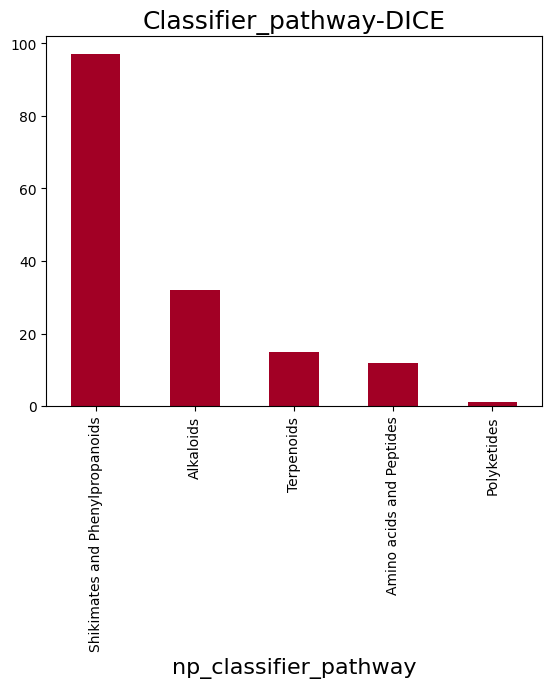

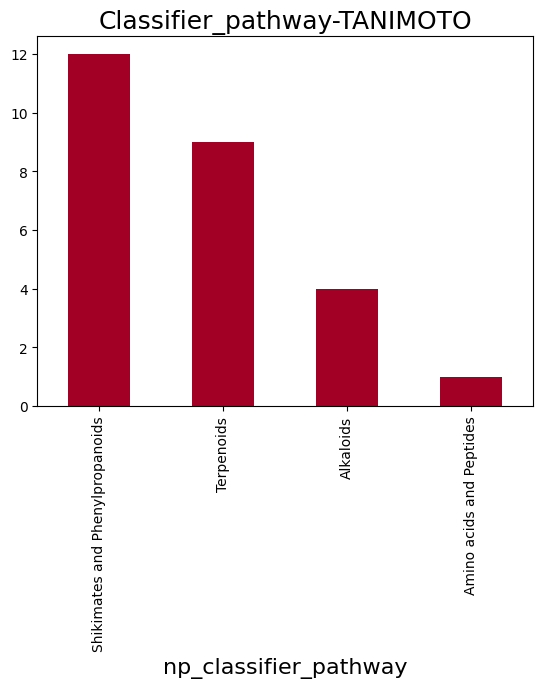

In [70]:
full_DICE["np_classifier_pathway"].value_counts().plot(kind="bar")
plt.title("Classifier_pathway-DICE")
plt.show()

full_TANIMOTO["np_classifier_pathway"].value_counts().plot(kind="bar")
plt.title("Classifier_pathway-TANIMOTO")
plt.show()



In [71]:
full_TANIMOTO.head()

,id,identifier,canonical_smiles,standard_inchi,standard_inchi_key,name,iupac_name,annotation_level,total_atom_count,heavy_atom_count,...,murcko_framework,np_likeness,chemical_class,chemical_sub_class,chemical_super_class,direct_parent_classification,np_classifier_pathway,np_classifier_superclass,np_classifier_class,np_classifier_is_glycoside
5673,744648,CNP0170523.1,COC1=CC2=C(C=C1OC)C(=O)[C@H](CC1CCN(CC3=CC=CC=...,InChI=1S/C24H29NO3/c1-27-22-14-19-13-20(24(26)...,ADEBPBSSDYVVLD-HXUWFJFHSA-N,(R)-donepezil,"(2~{R})-2-[(1-benzyl-4-piperidyl)methyl]-5,6-d...",3,57,28,...,c1ccc(cc1)CN2CCC(CC2)CC3Cc4ccccc4C3,-0.06,Piperidines,Benzylpiperidines,Organoheterocyclic compounds,N-benzylpiperidines,Alkaloids,Tyrosine alkaloids,Isoquinoline alkaloids,False
13738,940235,CNP0491444.1,COC1=CC=CC(C2=CC=CC(CC[C@]3(C)CC(=O)N(C)C(N)=N...,InChI=1S/C21H25N3O2/c1-21(14-19(25)24(2)20(22)...,VDFBMQAUECXNKR-OAQYLSRUSA-N,(6r)-2-Amino-6-[2-(3'-Methoxybiphenyl-3-Yl)eth...,(6~{R})-2-amino-6-[2-[3-(3-methoxyphenyl)pheny...,2,51,26,...,N1=CNCCC1CCc2cccc(c2)-c3ccccc3,0.05,Phenol ethers,Anisoles,Benzenoids,Anisoles,Alkaloids,NaN,NaN,False
15592,809978,CNP0167643.11,C[C@@H]1O[C@@H](OC2=C(C3=CC=C(O)C=C3)OC3=CC(O)...,InChI=1S/C21H20O10/c1-8-15(25)17(27)18(28)21(2...,SOSLMHZOJATCCP-PVFUPILZSA-N,NaN,"5,7-dihydroxy-2-(4-hydroxyphenyl)-3-[(2~{S},3~...",1,51,31,...,O1c2ccccc2CC(OC3OCCCC3)=C1c4ccccc4,2.08,Flavonoids,Flavonoid glycosides,Phenylpropanoids and polyketides,Flavonoid-3-O-glycosides,Shikimates and Phenylpropanoids,Flavonoids,Flavonols,True
17440,613580,CNP0281727.2,CC1O[C@@H](OC2=C(C3=CC=CC=C3)OC3=CC(O)=CC(O)=C...,InChI=1S/C21H20O9/c1-9-15(24)17(26)18(27)21(28...,HEAQNIWCWRHODF-RGEDYCASSA-N,Galangin 3-rhamnoside,"5,7-dihydroxy-2-phenyl-3-[(2~{S},3~{S},5~{R})-...",2,50,30,...,O1c2ccccc2CC(OC3OCCCC3)=C1c4ccccc4,2.02,Flavonoids,Flavonoid glycosides,Phenylpropanoids and polyketides,Flavonoid-3-O-glycosides,Shikimates and Phenylpropanoids,Flavonoids,Flavonols,True
18876,770976,CNP0286287.6,CC1(C)[C@H](O)CC[C@]2(C)[C@H]3CC[C@@H]4[C@@](C...,InChI=1S/C30H48O4/c1-26(2)23(33)10-13-28(4)19-...,QLFHDTVFRVKLCZ-PPOAAGDSSA-N,NaN,"(1~{S},6~{R},8~{R},11~{R},12~{S},15~{R},16~{R}...",1,82,34,...,C1=C2CC3CCC4CCCCC4C3CCC2C5CCCCC5C1,2.89,Prenol lipids,Triterpenoids,Lipids and lipid-like molecules,Serratane and onocerane triterpenoids,Terpenoids,Triterpenoids,Serratane triterpenoids,False


In [ ]:
tani